In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from skimage.io import imread, imshow
from scipy.ndimage import gaussian_filter
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head(10)



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


### Age, Gender and View Position Distribution for Entire Dataset

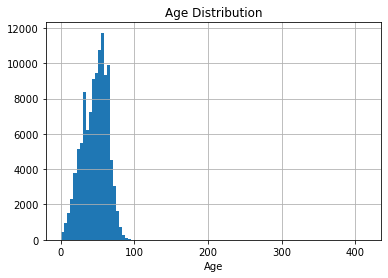

In [4]:
#Age Distribution
all_xray_df['Patient Age'].hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()


#### From the histogram we can see that there are patients beyond the age of 100. Let's check that again.

In [5]:
sum(all_xray_df['Patient Age']>100)

16

#### We can see that there are 16 patients with age more than 100 which means that for these patients the age entered was incorrect.

In [6]:
#Dropping patients with incorrect age
all_xray_df = all_xray_df[all_xray_df['Patient Age']<=100]

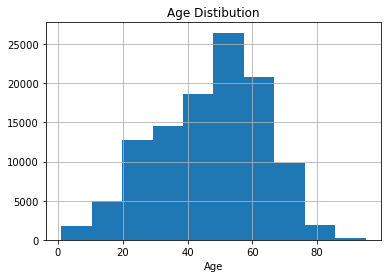

In [7]:
#Plotting Histogram for Age Distribution Again
all_xray_df['Patient Age'].hist()
plt.title('Age Distibution')
plt.xlabel('Age')
plt.show()

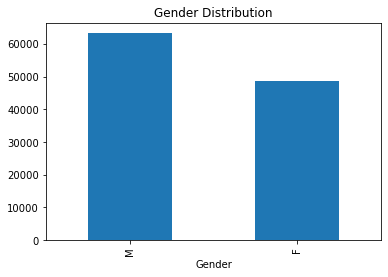

In [8]:
#Gender Distribution
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.show()

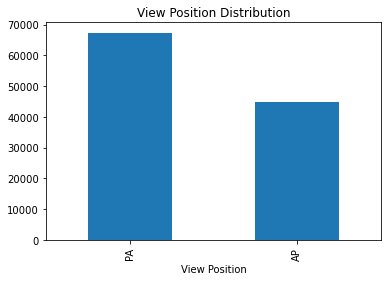

In [9]:
#View Position Distribution
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution')
plt.xlabel('View Position')
plt.show()

In [10]:
#Separating the labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df = all_xray_df.drop(['Unnamed: 11'],axis=1)

In [11]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Number of Cases

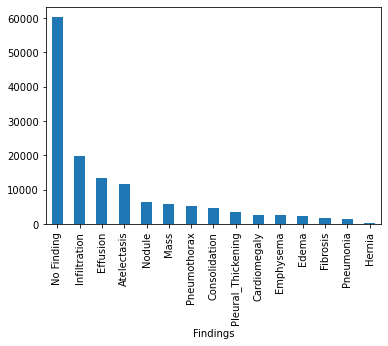

In [12]:
#Getting counts for every disease
all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Findings')
plt.show()

### Distribution of Other Diseases that are Comorbid with Pneumonia

#### We need to check which disease is highly correlated with Pneumonia

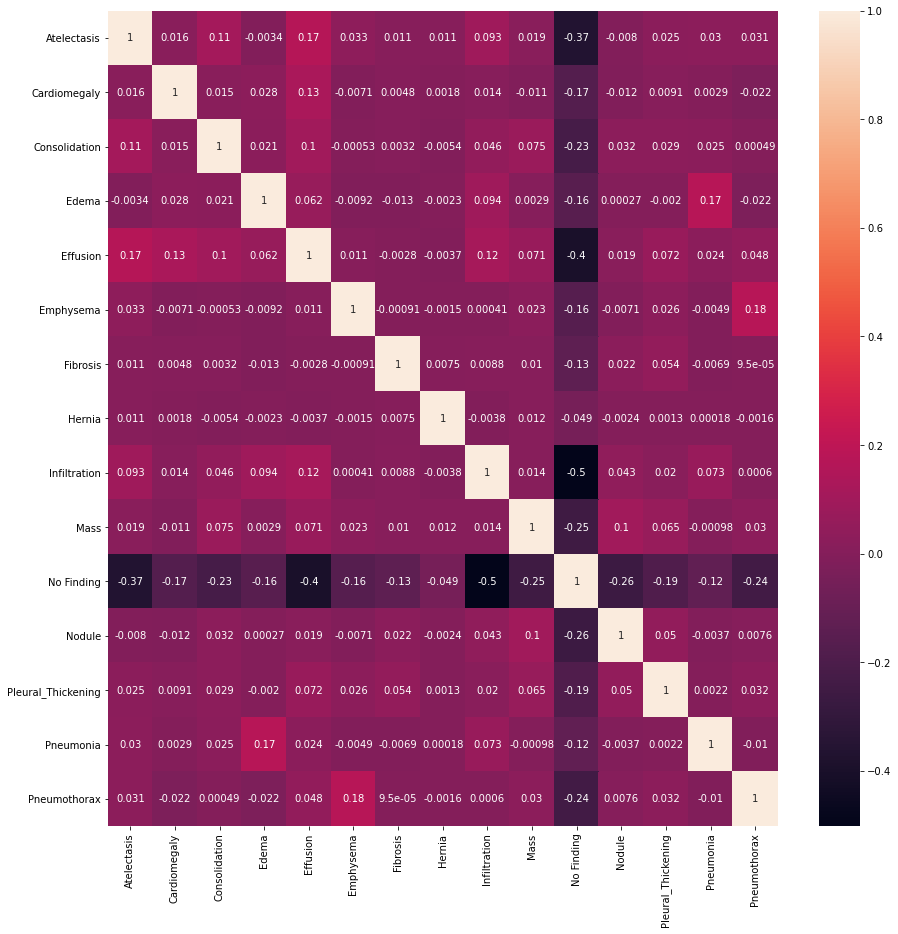

In [13]:
plt.figure(figsize=(15,15))
corrMatrix = all_xray_df[all_labels].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### From the correlation matrix we can see that Pneumonia is highly correlated with Infiltration and Atelectasis.

### Age, Gender and View Position Distribution for Patients with Pnuemonia

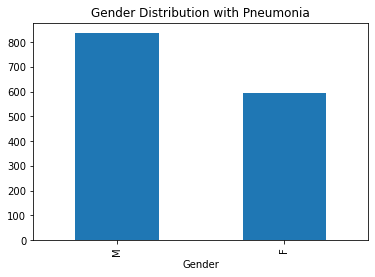

In [14]:
#Gender Distribution
all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution with Pneumonia')
plt.xlabel('Gender')
plt.show()

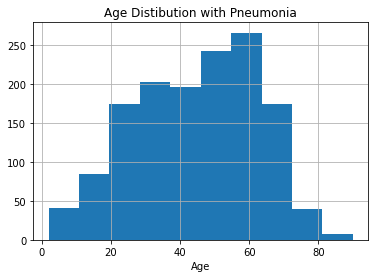

Minimum Age:  2
Maximum Age:  90


In [15]:
#Age Distribution
all_xray_df[all_xray_df['Pneumonia']==1]['Patient Age'].hist()
plt.title('Age Distibution with Pneumonia')
plt.xlabel('Age')
plt.show()
print('Minimum Age: ',all_xray_df[all_xray_df['Pneumonia']==1]['Patient Age'].min())
print('Maximum Age: ',all_xray_df[all_xray_df['Pneumonia']==1]['Patient Age'].max())

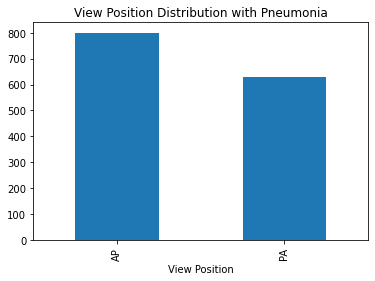

In [16]:
#View Positon Distribution
all_xray_df[all_xray_df['Pneumonia']==1]['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution with Pneumonia')
plt.xlabel('View Position')
plt.show()

### Age, Gender and View Position Distribution for Patients with Infiltration

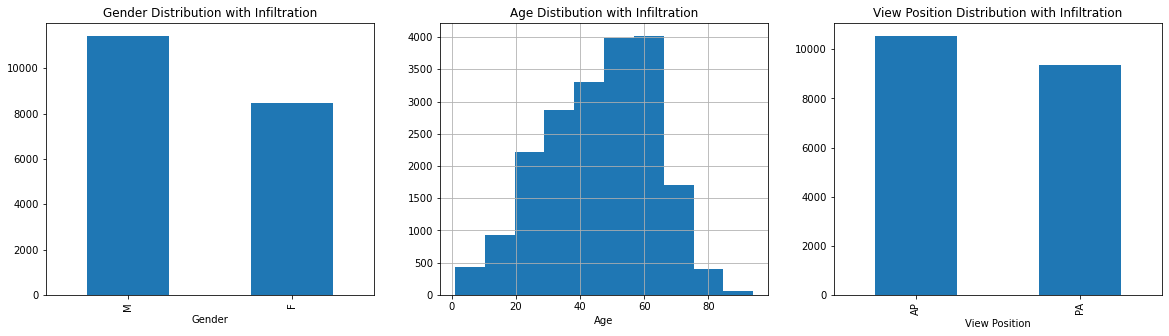

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
#Gender Distribution
all_xray_df[all_xray_df['Infiltration']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution with Infiltration')
plt.xlabel('Gender')


plt.subplot(1,3,2)
#Age Distribution
all_xray_df[all_xray_df['Infiltration']==1]['Patient Age'].hist()
plt.title('Age Distibution with Infiltration')
plt.xlabel('Age')

plt.subplot(1,3,3)
#View Positon Distribution
all_xray_df[all_xray_df['Infiltration']==1]['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution with Infiltration')
plt.xlabel('View Position')
plt.show()

### Age, Gender and View Position Distribution for Patients with Atelectasis

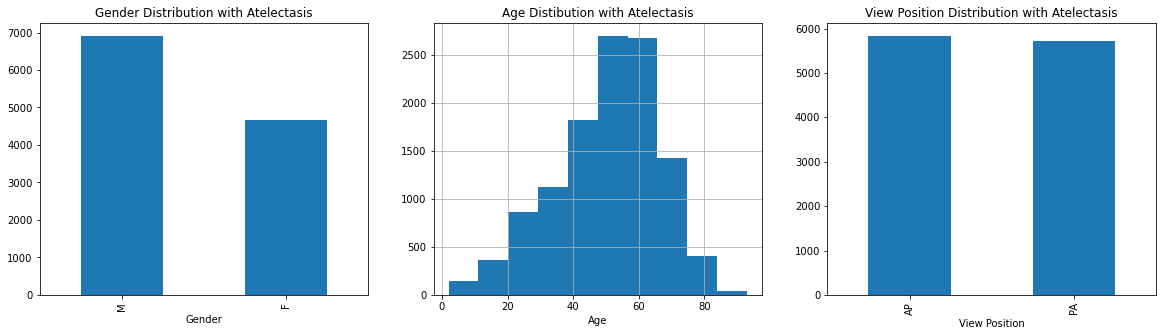

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
#Gender Distribution
all_xray_df[all_xray_df['Atelectasis']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution with Atelectasis')
plt.xlabel('Gender')


plt.subplot(1,3,2)
#Age Distribution
all_xray_df[all_xray_df['Atelectasis']==1]['Patient Age'].hist()
plt.title('Age Distibution with Atelectasis')
plt.xlabel('Age')

plt.subplot(1,3,3)
#View Positon Distribution
all_xray_df[all_xray_df['Atelectasis']==1]['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution with Atelectasis')
plt.xlabel('View Position')
plt.show()

### Number of Cases Per Patient with Pneumonia Positive

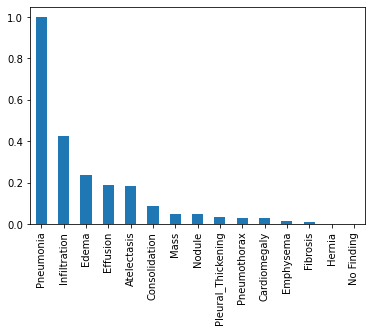

In [19]:
(all_xray_df[all_xray_df['Pneumonia']==1][all_labels].sum()/len(all_xray_df[all_xray_df['Pneumonia']==1])).sort_values(ascending = False).plot(kind='bar')

### Pixel-level Assessments of the Imaging Data for Healthy & Disease States of Interest

In [20]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [21]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [22]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path_img
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_001.png


In [23]:
#Separating the labels
all_labels_s = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels_s = [x for x in all_labels_s if len(x)>0]
for c_label in all_labels_s:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pixel Level Analysis for Patients with Pneumonia

In [24]:
new = sample_df[sample_df['Pneumonia']==1].sample(5).reset_index(drop=True) #Consider random 5 samples from patients with 
                                                                            #Pneumonia Positive

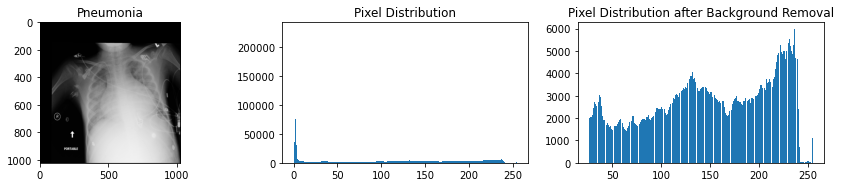

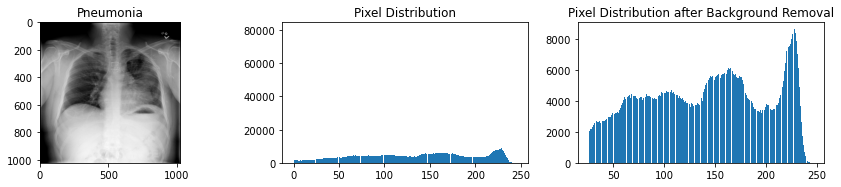

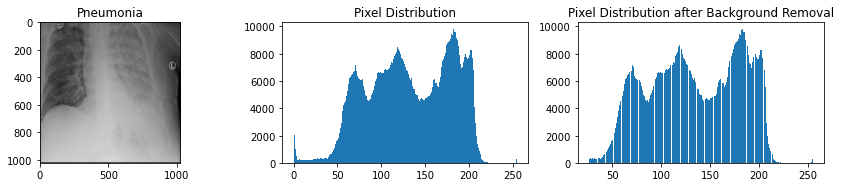

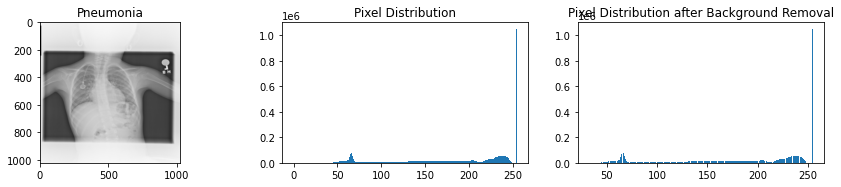

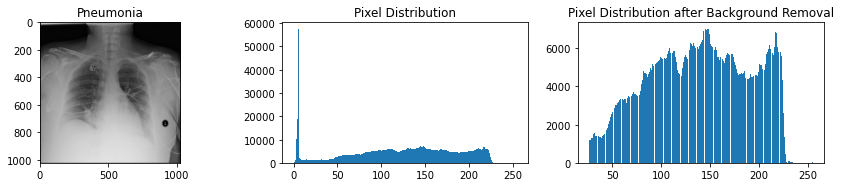

In [25]:
j = 1
thresh = 25
for i in range(len(new)):
    plt.figure(figsize=(15,15))
    plt.subplot(5,3,j)
    a = imread(new['path_img'][i])
    plt.imshow(a,cmap='gray')
    plt.title('Pneumonia')
    
    plt.subplot(5,3,j+1)
    plt.hist(a.ravel(),bins = 256)
    plt.title('Pixel Distribution')
    
    plt.subplot(5,3,j+2)
    img_mask = (a > thresh)
    plt.hist(a[img_mask].ravel(),bins=256)
    plt.title('Pixel Distribution after Background Removal')
    
    j += 3 

### Pixel Level Analysis for Healthy Patients


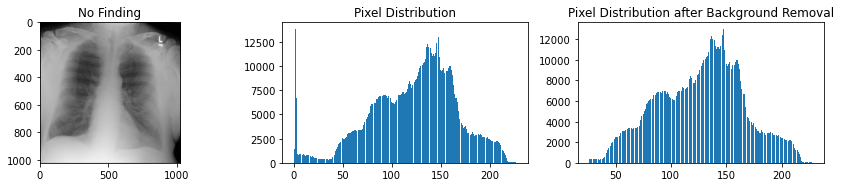

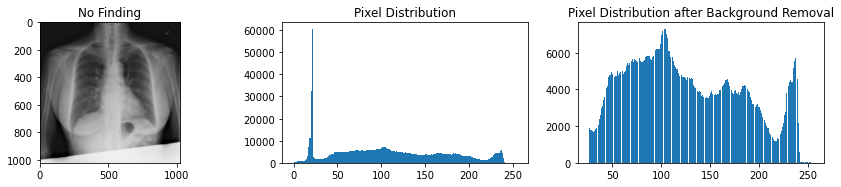

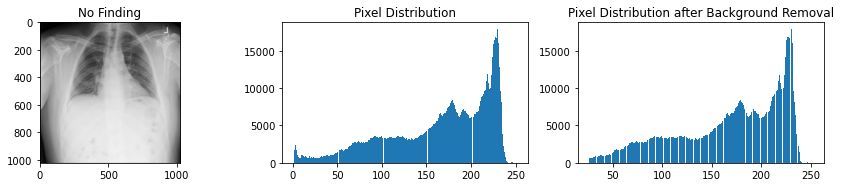

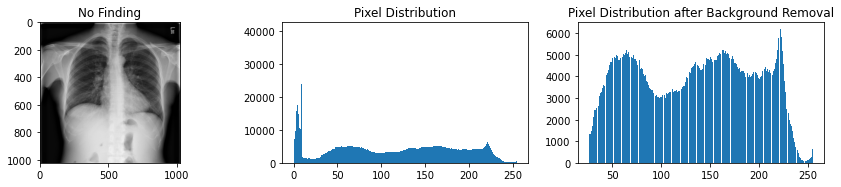

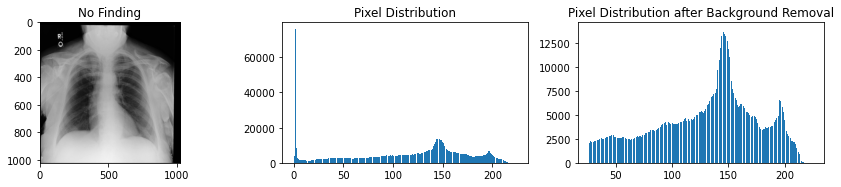

In [26]:
new = sample_df[sample_df['No Finding']==1].sample(5).reset_index(drop=True) #Consider random 5 samples from patients with 
                                                                            #No fining
j = 1
thresh = 25
for i in range(len(new)):
    plt.figure(figsize=(15,15))
    plt.subplot(5,3,j)
    a = imread(new['path_img'][i])
    plt.imshow(a,cmap='gray')
    plt.title('No Finding')
    
    plt.subplot(5,3,j+1)
    plt.hist(a.ravel(),bins = 256)
    plt.title('Pixel Distribution')
    
    plt.subplot(5,3,j+2)
    img_mask = (a > thresh)
    plt.hist(a[img_mask].ravel(),bins=256)
    plt.title('Pixel Distribution after Background Removal')
    
    j += 3 

### Pixel Level Analysis for Patients with Infiltration

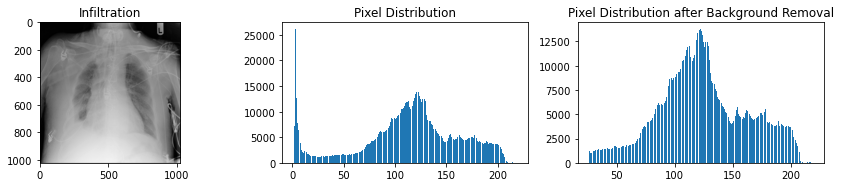

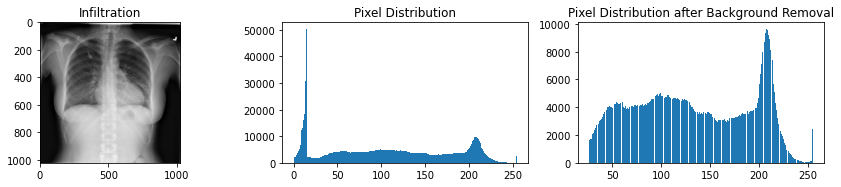

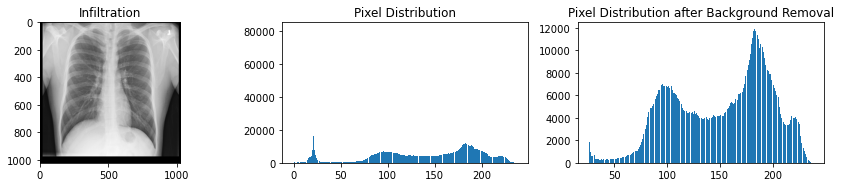

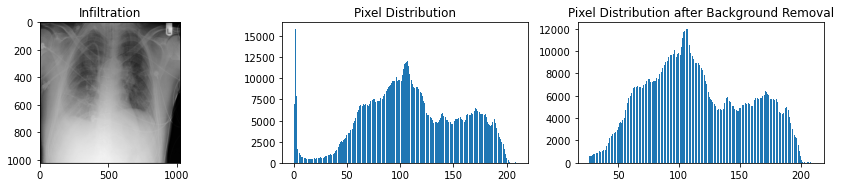

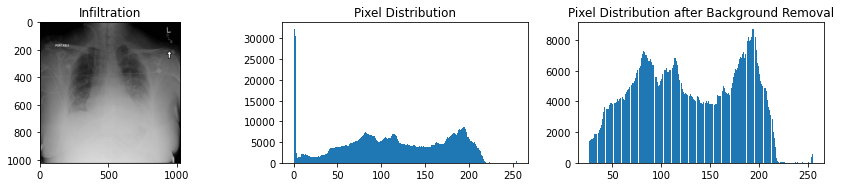

In [27]:
new = sample_df[sample_df['Infiltration']==1].sample(5).reset_index(drop=True) #Consider random 5 samples from patients with 
                                                                            #Infiltration Positive
j = 1
thresh = 25
for i in range(len(new)):
    plt.figure(figsize=(15,15))
    plt.subplot(5,3,j)
    a = imread(new['path_img'][i])
    plt.imshow(a,cmap='gray')
    plt.title('Infiltration')
    
    plt.subplot(5,3,j+1)
    plt.hist(a.ravel(),bins = 256)
    plt.title('Pixel Distribution')
    
    plt.subplot(5,3,j+2)
    img_mask = (a > thresh)
    plt.hist(a[img_mask].ravel(),bins=256)
    plt.title('Pixel Distribution after Background Removal')
    
    j += 3 

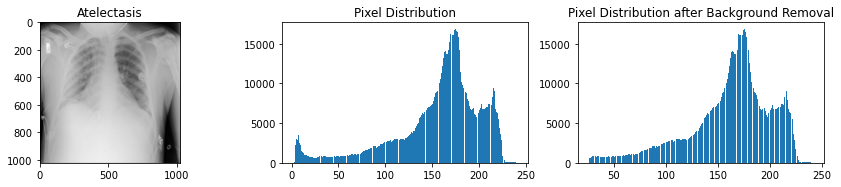

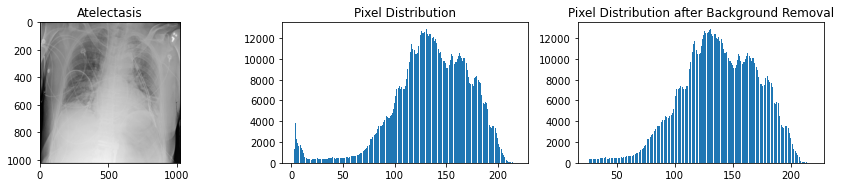

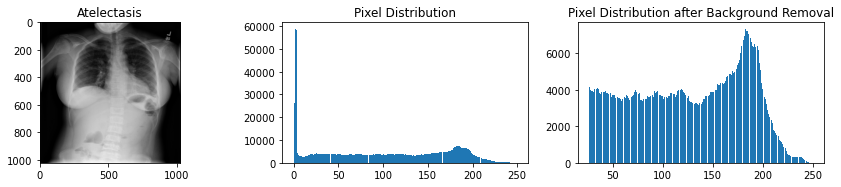

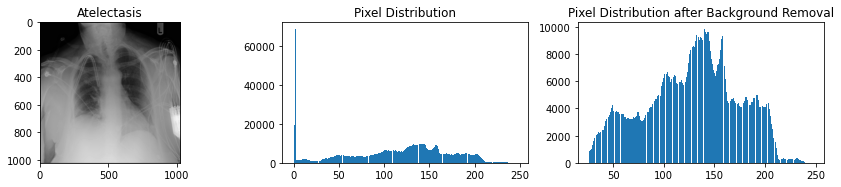

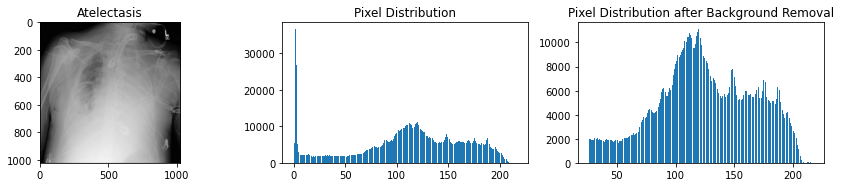

In [28]:
new = sample_df[sample_df['Atelectasis']==1].sample(5).reset_index(drop=True) #Consider random 5 samples from patients with 
                                                                            #Atelectasis Positive
j = 1
thresh = 25
for i in range(len(new)):
    plt.figure(figsize=(15,15))
    plt.subplot(5,3,j)
    a = imread(new['path_img'][i])
    plt.imshow(a,cmap='gray')
    plt.title('Atelectasis')
    
    plt.subplot(5,3,j+1)
    plt.hist(a.ravel(),bins = 256)
    plt.title('Pixel Distribution')
    
    plt.subplot(5,3,j+2)
    img_mask = (a > thresh)
    plt.hist(a[img_mask].ravel(),bins=256)
    plt.title('Pixel Distribution after Background Removal')
    
    j += 3 

### Reflection:
1. The intensity values for pneumonia patients peaked around 100 - 150 in most cases.
2. The number of pneumonia cases is very less in the whole dataset and hence image augmentation will be helpful
3. Pneumonia seems to be highly correlated with infiltration and atelectasis and even for them the peak intensities lie between    100-150 in most cases.
4. For healthy patients the peak was in betweeb 150-250.


